# imports & config

In [1]:
import os
import time
import logging
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Dense, LSTM, GRU, Conv1D, MaxPooling1D, 
                                     Dropout, BatchNormalization)
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

# ignore errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# paths
TRAIN_CSV_PATH = '/kaggle/input/asl-signs/train.csv'
LANDMARK_DIR = '/kaggle/input/asl-signs'
OUTPUT_PATH = 'MP_Data'

# target classes
TARGET_WORDS = ['hello', 'no', 'yes', 'please', 'book', 'drink', 'bye', 'bad']

print("libraries loaded")

2025-12-24 21:20:08.434233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766611208.458989    3025 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766611208.466324    3025 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766611208.494629    3025 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766611208.494664    3025 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766611208.494668    3025 computation_placer.cc:177] computation placer alr

libraries loaded


# data processing

In [2]:
# create output directories
for word in TARGET_WORDS:
    os.makedirs(os.path.join(OUTPUT_PATH, word), exist_ok=True)

def process_parquet_file(parquet_path):

    try:
        df = pd.read_parquet(parquet_path)
        frames = sorted(df['frame'].unique())
        
        if len(frames) < 1: 
            return None
        
        # Select 30 frames
        indices = np.linspace(0, len(frames)-1, 30, dtype=int)
        selected_frames = [frames[i] for i in indices]
        
        sequences = []
        for frame_idx in selected_frames:
            frame_data = df[df['frame'] == frame_idx]
            values = np.zeros(1629) 
            
            if not frame_data.empty:
                 frame_data = frame_data.sort_values(by=['type', 'landmark_index'])
                 flat_vals = frame_data[['x', 'y', 'z']].values.flatten()
                 if len(flat_vals) == 1629:
                     values = np.nan_to_num(flat_vals)
            sequences.append(values)
            
        return np.array(sequences)
    except Exception as e:
        return None

# processing loop
print(f"Loading from {TRAIN_CSV_PATH}...")
df = pd.read_csv(TRAIN_CSV_PATH)
subset_df = df[df['sign'].isin(TARGET_WORDS)]
total_processed = 0

for word in TARGET_WORDS:
    word_df = subset_df[subset_df['sign'] == word]
    start_time = time.time()
    files_saved = 0
    
    print(f"Processing class '{word}' ({len(word_df)} samples)...")
    
    for idx, row in word_df.iterrows():
        parquet_path = os.path.join(LANDMARK_DIR, 'train_landmark_files', 
                                    str(row['participant_id']), f'{row["sequence_id"]}.parquet')
        save_path = os.path.join(OUTPUT_PATH, word, f"{row['sequence_id']}.npy")
        
        data = process_parquet_file(parquet_path)
        
        if data is not None and data.shape == (30, 1629):
            np.save(save_path, data)
            files_saved += 1
            total_processed += 1
            
    elapsed = time.time() - start_time
    print(f"Saved {files_saved} sequences in {elapsed:.1f}s")

print(f"\n Processing complete. Total sequences: {total_processed}")

Loading from /kaggle/input/asl-signs/train.csv...
Processing class 'hello' (390 samples)...
Saved 390 sequences in 22.4s
Processing class 'no' (370 samples)...
Saved 370 sequences in 21.2s
Processing class 'yes' (386 samples)...
Saved 386 sequences in 22.6s
Processing class 'please' (384 samples)...
Saved 384 sequences in 22.9s
Processing class 'book' (368 samples)...
Saved 368 sequences in 21.1s
Processing class 'drink' (400 samples)...
Saved 400 sequences in 22.1s
Processing class 'bye' (402 samples)...
Saved 402 sequences in 22.1s
Processing class 'bad' (376 samples)...
Saved 376 sequences in 20.2s

 Processing complete. Total sequences: 3076


# data loading & splitting

In [3]:
# detect and map labels
if not os.path.exists(OUTPUT_PATH):
    raise FileNotFoundError(f"Output path '{OUTPUT_PATH}' not found.")

found_labels = sorted([name for name in os.listdir(OUTPUT_PATH) 
                       if os.path.isdir(os.path.join(OUTPUT_PATH, name))])
label_map = {label: num for num, label in enumerate(found_labels)}
print(f"Detected Classes: {found_labels}")

# load data into memory
sequences, labels = [], []
print("Loading data into memory...")

for word, label_id in label_map.items():
    word_path = os.path.join(OUTPUT_PATH, word)
    for file_name in os.listdir(word_path):
        file_path = os.path.join(word_path, file_name)
        res = np.load(file_path)
        if res.shape == (30, 1629):
            sequences.append(res)
            labels.append(label_id)

X = np.array(sequences)
y = to_categorical(labels).astype(int)

# split (15% Test Set)
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# compute class weights
# handles class imbalances during training
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights_dict = dict(enumerate(class_weights))

print(f"Data loaded successfully.")
print(f" - X_train shape: {X_train.shape}")
print(f" - X_test shape:  {X_test.shape}")

Detected Classes: ['bad', 'book', 'bye', 'drink', 'hello', 'no', 'please', 'yes']
Loading data into memory...
Splitting data...
Data loaded successfully.
 - X_train shape: (2614, 30, 1629)
 - X_test shape:  (462, 30, 1629)


# augmentation

In [4]:
def augment_data(X, y, noise_level=0.05):
    
    augmented_X = []
    augmented_y = []
    
    print(f"Augmenting {len(X)} samples with noise_level={noise_level}...")
    
    for i in range(len(X)):
        # 1. Keep Original
        augmented_X.append(X[i])
        augmented_y.append(y[i])
        
        noise = np.random.normal(0, noise_level, X[i].shape)
        jittered_sequence = X[i] + noise
        
        augmented_X.append(jittered_sequence)
        augmented_y.append(y[i])
        
    return np.array(augmented_X), np.array(augmented_y)

# apply augmentation only to training set
X_train, y_train = augment_data(X_train, y_train)

print(f"Augmentation complete.")
print(f" - New Training Size: {X_train.shape}")

Augmenting 2614 samples with noise_level=0.05...
Augmentation complete.
 - New Training Size: (5228, 30, 1629)


# training

In [5]:
# hybrid architecture definition
model = Sequential([
    # CNN Spatial Feature Extraction
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(30, 1629)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    # LSTM Temporal Features (Short-term)
    LSTM(64, return_sequences=True, activation='tanh',
         kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
    Dropout(0.3),

    # GRU Temporal Features (Long-term efficient)
    GRU(128, return_sequences=False, activation='tanh',
        kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
    Dropout(0.3),

    # Dense Classification
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),

    # Output Layer
    Dense(len(label_map), activation='softmax')
])

# compile model
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for stability
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

model.summary()

# callbacks
callbacks = [
    EarlyStopping(monitor='val_categorical_accuracy', patience=20, restore_best_weights=True),
    ModelCheckpoint('final_model.keras', monitor='val_categorical_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=0.00001)
]

# Train Model
print(f"\nStarting training on {len(X_train)} samples...")
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1766611393.069632    3025 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │       312,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 14, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,208 (1.64 MB)

 Trainable params: 431,080 (1.64 MB)

 Non-trainable params: 128 (512.00 B)


Starting training on 5228 samples...
Epoch 1/150


I0000 00:00:1766611400.164657    3085 cuda_dnn.cc:529] Loaded cuDNN version 91002


164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - categorical_accuracy: 0.1418 - loss: 6.6219 - val_categorical_accuracy: 0.1429 - val_loss: 5.6676 - learning_rate: 1.0000e-04
Epoch 2/150
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.1547 - loss: 5.3961 - val_categorical_accuracy: 0.1320 - val_loss: 4.7270 - learning_rate: 1.0000e-04
Epoch 3/150
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.1990 - loss: 4.5017 - val_categorical_accuracy: 0.2814 - val_loss: 4.0022 - learning_rate: 1.0000e-04
Epoch 4/150
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.2431 - loss: 3.8165 - val_categorical_accuracy: 0.1299 - val_loss: 3.6093 - learning_rate: 1.0000e-04
Epoch 5/150
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - categorical_accuracy: 0.2816 - loss: 3.2906 - val_categorical_accuracy: 0.1277 - val_loss: 4.3605 - learning_rate: 1.0000e-04
Epoch 6/150
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - categorical_accuracy: 0.2790 - loss: 2.9426 - 

# evaluation & visualization

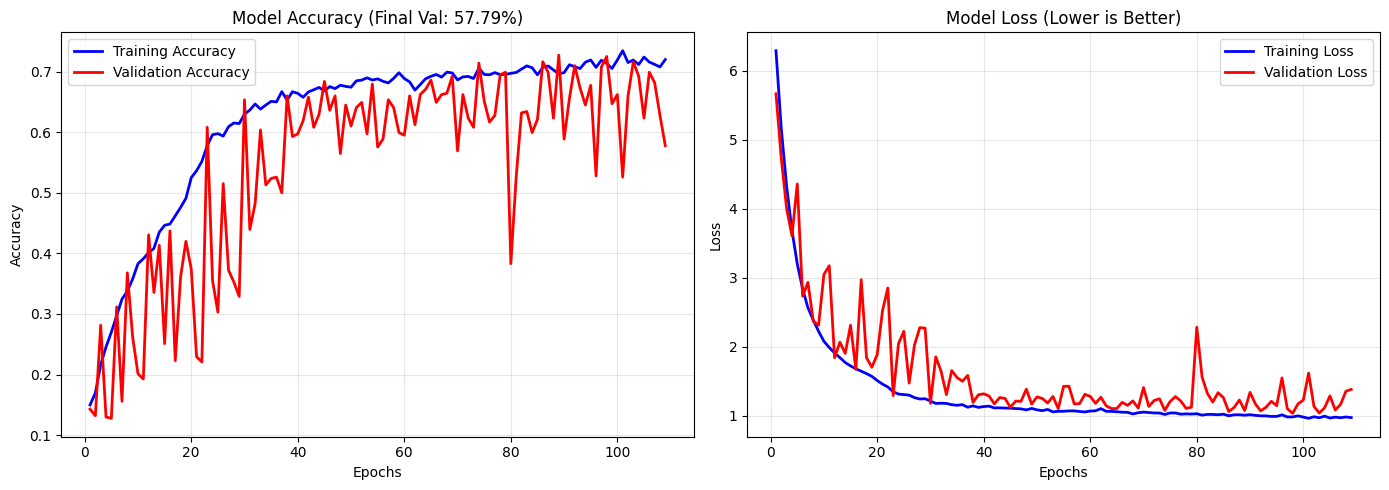

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


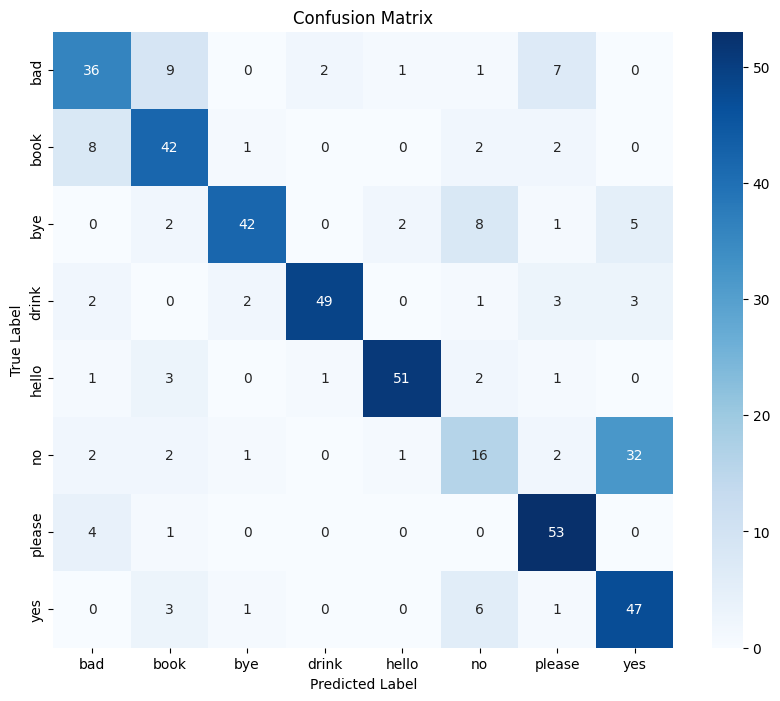


 classification report:
              precision    recall  f1-score   support

         bad       0.68      0.64      0.66        56
        book       0.68      0.76      0.72        55
         bye       0.89      0.70      0.79        60
       drink       0.94      0.82      0.88        60
       hello       0.93      0.86      0.89        59
          no       0.44      0.29      0.35        56
      please       0.76      0.91      0.83        58
         yes       0.54      0.81      0.65        58

    accuracy                           0.73       462
   macro avg       0.73      0.72      0.72       462
weighted avg       0.74      0.73      0.72       462



In [6]:
def plot_training_history(history):
    
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    #accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    plt.title(f'Model Accuracy (Final Val: {val_acc[-1]*100:.2f}%)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    #loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)
    plt.title('Model Loss (Lower is Better)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1])]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n classification report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))